# ANN 6D pose estimator in Tensorflow

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

from scipy import interpolate
from scipy.spatial.transform import Rotation
from scipy.sparse import csr_matrix, vstack, save_npz, load_npz

from mpl_toolkits.mplot3d import Axes3D

from scipy.spatial import ConvexHull, Delaunay

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, InputLayer, Conv1D, MaxPooling1D, Flatten, Dense, LeakyReLU, Dropout, BatchNormalization
from keras.losses import mean_squared_error, mean_absolute_percentage_error

from tqdm import tqdm
import time

np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:2.5f}".format(x)})


### google drive backup operations

In [ ]:
# mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy files back and forth

# !cp *.npz /content/drive/MyDrive/ba/6d_shifted_pose
# !cp *.npy /content/drive/MyDrive/ba/6d_shifted_pose
# !cp *.keras /content/drive/MyDrive/ba/6d_shifted_pose
# !cp /content/drive/MyDrive/ba/pihalf_l2_1deg_steps/*.npy .

In [ ]:
# save/load models

conv_model.save('/content/drive/MyDrive/ba/6d_shifted_pose/conv-model-32ep.keras')
# conv_model.save('./temp-conv_model.keras')
# conv_model.save('/content/drive/MyDrive/ba/pihalf_l2/pihalf-model-l2-30ep.h5')
# !cp *.h5 /content/drive/MyDrive/ba/
# conv_model = tf.keras.models.load_model('/content/drive/MyDrive/ba/6d_shifted_pose/conv-model-32ep.keras')

### Initialize Forward Model

In [2]:
features = {
    'p1': np.array([0, -25, -43.30]),
    'p2': np.array([100, -25, -43.30]),
    'p3': np.array([0, 61.60, -93.30]),
    'p4': np.array([100, 111.60, -6.70]),
    'p5': np.array([100, 25, 43.30]),
    'p6': np.array([0, 111.60, -6.70]),
}

C = 1000
sensors = {
    's1': np.array([0, -C, 0]),
    's2': np.array([C, 0, 0]),
    's3': np.array([0, 0, C])
}

# rigid body transformation x,y,z-axis <------- für trainingsdaten
def p1_xyz(z, w, alpha):
    R_x = Rotation.from_euler('x', alpha[0])
    R_y = Rotation.from_euler('y', alpha[1])
    R_z = Rotation.from_euler('z', alpha[2])
    return R_z.apply(R_y.apply(R_x.apply(z + w)))

# observational function of multilateration
def p2(z, w, alpha, gamma):
    u = p1_xyz(z, w, alpha)
    return np.linalg.norm(u-gamma)

### Set value ranges for training data

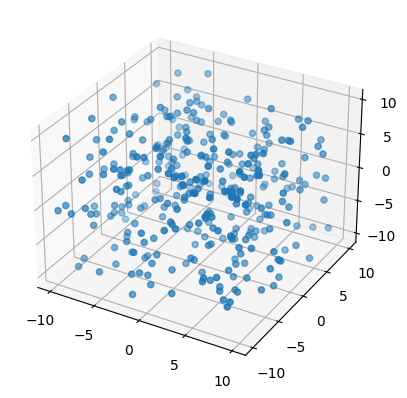

In [3]:
def lhs(dim, n_samples, low=0, high=1):
    """Returns a latin hypercube whose samples are split into equally spaced intervals.
    Works with multidimensional boundaries.

    Args:
        dim (int): dimension
        n_samples (int): number of samples in each dimension.
        low (int, optional): lower boundary of samples. Can be a vector. Defaults to 0.
        high (int, optional): upper boundary of samples. Can be a vector. Defaults to 1.

    Returns:
        np.array: 2d hypercube of samples
    """
    rand_matrix = np.empty((n_samples, dim))
    subintervals, stepsize = np.linspace(0, 1, n_samples+1, retstep=True)

    # generate uniformely distributed samples
    for i in range(dim):
        for j, min in enumerate(subintervals[:-1]):
            rand_matrix[j, i] = np.random.uniform(min, min+stepsize)

    # permute the columns
    for i in range(dim):
        rand_matrix[:, i] = np.random.permutation(rand_matrix[:, i])

    return rand_matrix * (high - low) + low

# sample latin hypercube inside +- 10 mm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
lhs_coords = lhs(3, 350, -10, 10)
ax.scatter(lhs_coords[:, 0], lhs_coords[:, 1], lhs_coords[:, 2])
plt.show()

In [ ]:
(1.8/360)*2*np.pi

0.031415926535897934

In [ ]:
np.pi/18/6

0.02908882086657216

In [4]:
# rotation angles
# ---------------------------
# step_size = (1.8/360)*2*np.pi
step_size = np.pi/18/8

# roll E [0, 360]
roll_range = np.arange(-np.pi/36, np.pi/36 + step_size, step_size) #lhs

# pitch E ]-90, 90[
pitch_range = np.arange(-np.pi/36, np.pi/36 + step_size, step_size) #lhs

# yaw E [0, 360]
# yaw_range = np.arange(-np.pi/3 - np.pi/36, -np.pi/3 + np.pi/36 + step_size, step_size) #lhs
yaw_range = np.arange(-np.pi/36, np.pi/36 + step_size, step_size) #lhs

timesteps = 900
feature_channels = 3
x = np.linspace(500, 1500, timesteps)

train_size_len = len(lhs_coords) * len(yaw_range) * len(pitch_range) * len(roll_range)
num_rotations_len = len(yaw_range) * len(pitch_range) * len(roll_range)

print(f"train size len: {train_size_len}")
print(f"num rotations: {num_rotations_len}")

train size len: 255150
num rotations: 729


In [5]:
num_rotations = 9#int((np.pi/18)/step_size)

lhs_roll_range = np.sort(lhs(1, num_rotations , roll_range[0], roll_range[-1]).flatten())
lhs_pitch_range = np.sort(lhs(1, num_rotations , pitch_range[0], pitch_range[-1]).flatten())
lhs_yaw_range = np.sort(lhs(1, num_rotations , yaw_range[0], yaw_range[-1]).flatten())
len(lhs_pitch_range)

9

In [ ]:
pitch_range


array([-0.0873, -0.0654, -0.0436, -0.0218, 0.0000, 0.0218, 0.0436, 0.0654,
       0.0873])

### Generate Training data

In [ ]:
points = np.row_stack(list(features.values()))
w0 = np.zeros(3) # + add standard pose from paper
V0 = np.zeros(3) # + add standard pose from paper

delta_w = np.ones(3)*40
alpha = np.array([0, 0, -np.pi*(1/3)])

w0 = w0 + delta_w
V0 = V0 + alpha

print("Generating training dataset...")

for count, delta_w in enumerate(lhs_coords):
    print(f"- rotations at delta w: {delta_w} ({count+1}/{len(lhs_coords)})")

    samples_list = []
    Y_train = None

    lhs_yaw_range = np.sort(lhs(1, num_rotations , yaw_range[0], yaw_range[-1]).flatten())  # sample yaw angles
    for psi in tqdm(lhs_yaw_range, total=len(lhs_yaw_range)):

        lhs_pitch_range = np.sort(lhs(1, num_rotations, pitch_range[0], pitch_range[-1]).flatten())  # sample pitch angles
        for theta in lhs_pitch_range:

            lhs_roll_range = np.sort(lhs(1, num_rotations, roll_range[0], roll_range[-1]).flatten())  # sample roll angles
            for phi in lhs_roll_range:

                # --------------------------------------------------------------
                alpha = np.array([phi, theta, psi])
                V = V0 + alpha
                w = w0 + delta_w
                points_new = points.copy()

                for i in range(len(points_new)):
                    points_new[i] = p1_xyz(points_new[i], w, V)
                # --------------------------------------------------------------

                x_train_sample = np.zeros((feature_channels, timesteps))

                for i, (_, sensor_pos) in enumerate(sensors.items()):

                    distances = []
                    for p in points_new:
                        distances.append(p2(p, w, V, sensor_pos))

                    y = np.zeros_like(x)
                    sigma = 5

                    for d in distances:
                        # add a gaussian kernel for each distance
                        gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
                        y += gaussian_norm_const  * np.exp(-((x - d)**2) / (2 * sigma**2))

                    x_train_sample[i, :] = y

                # append X data sample
                samples_list.append(x_train_sample)

                # append Y data sample
                V = V*(180/np.pi)  # rad to deg
                true_pose = np.concatenate((w, V))

                if Y_train is None:
                    Y_train = true_pose
                else:
                    Y_train = np.vstack([Y_train, true_pose])

    # convert into sparse matrix
    sp_rows = [csr_matrix(row) for row in samples_list]
    sp_data = vstack(sp_rows)

    # save training data to disk
    save_npz(f'X_train_{count}.npz', sp_data)
    np.save(f'Y_train_{count}.npy', Y_train)

# special cases at pitch pi/2 and -pi/2
# insert code here

Generating training dataset...
- rotations at delta w: [-0.3777 2.7958 5.5604] (1/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [5.7803 -7.1417 -0.2002] (2/350)


100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


- rotations at delta w: [8.6230 9.1264 -3.0226] (3/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [6.3664 -5.0125 -9.5123] (4/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [-0.9977 1.8678 -3.4019] (5/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-9.1820 -2.7928 7.0456] (6/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [6.9265 4.7632 -9.2155] (7/350)


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


- rotations at delta w: [-4.9920 -4.8404 2.4504] (8/350)


100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


- rotations at delta w: [-1.8181 -2.3348 9.6111] (9/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [0.6764 -1.9346 -3.6758] (10/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [5.1858 5.4051 -8.3028] (11/350)


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


- rotations at delta w: [-0.0993 5.0680 -3.6257] (12/350)


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


- rotations at delta w: [-9.3540 0.5353 5.1384] (13/350)


100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


- rotations at delta w: [0.3667 -4.8756 1.5822] (14/350)


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


- rotations at delta w: [-3.7000 8.7554 7.8327] (15/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [-6.7963 -0.2835 1.9630] (16/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [2.0591 6.7295 6.0471] (17/350)


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


- rotations at delta w: [2.6297 8.0382 8.9296] (18/350)


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


- rotations at delta w: [-8.2404 9.5804 -6.2593] (19/350)


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


- rotations at delta w: [-4.1459 -3.1262 9.5296] (20/350)


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


- rotations at delta w: [-4.3627 0.2347 -6.5340] (21/350)


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


- rotations at delta w: [5.7349 -5.3062 -9.9157] (22/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [0.5038 -8.9272 -7.0496] (23/350)


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


- rotations at delta w: [-0.4558 4.0491 2.0779] (24/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [-2.0057 -1.5707 4.7870] (25/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [7.4251 -8.6149 -6.8786] (26/350)


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


- rotations at delta w: [7.3494 9.2065 6.7231] (27/350)


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


- rotations at delta w: [0.3021 5.8186 -4.8637] (28/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [-9.9499 -4.9514 4.1777] (29/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [-2.8322 -5.7386 -5.2732] (30/350)


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


- rotations at delta w: [-0.4890 -3.0055 3.5011] (31/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [0.7060 -1.8660 0.8958] (32/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [-7.2468 -6.7497 -2.6461] (33/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [-3.3517 3.7299 -1.3434] (34/350)


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


- rotations at delta w: [-0.8720 3.1591 3.7621] (35/350)


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


- rotations at delta w: [-3.8523 3.4428 9.9731] (36/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [-8.6524 5.1636 -5.4920] (37/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [-4.7264 -9.2284 -7.7688] (38/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [-9.8293 1.1445 5.7315] (39/350)


100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


- rotations at delta w: [3.3251 3.6033 1.4827] (40/350)


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


- rotations at delta w: [8.0867 -2.5664 1.0466] (41/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [8.1462 -2.8819 -2.2496] (42/350)


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


- rotations at delta w: [0.8014 8.4325 -4.2277] (43/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [-4.2443 -9.6674 2.0359] (44/350)


100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


- rotations at delta w: [-4.5402 9.3148 0.5511] (45/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [4.5848 -3.2305 6.5762] (46/350)


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


- rotations at delta w: [1.9012 -7.4997 -3.5430] (47/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [1.1758 -0.6798 -3.3035] (48/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-9.0529 -8.7697 -7.9271] (49/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [3.0313 5.2131 -9.5568] (50/350)


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


- rotations at delta w: [-1.7641 3.0313 -4.7888] (51/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [4.4703 1.5891 0.7159] (52/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [1.3422 -0.3787 -5.4201] (53/350)


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


- rotations at delta w: [8.9499 -5.5561 8.3859] (54/350)


100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


- rotations at delta w: [-8.4088 8.9069 -6.7259] (55/350)


100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


- rotations at delta w: [-8.0980 -1.0777 -2.7382] (56/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-2.1116 -8.3797 -3.4636] (57/350)


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


- rotations at delta w: [-3.7385 4.9437 8.8881] (58/350)


100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


- rotations at delta w: [0.7643 -9.9699 -0.6713] (59/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [-2.5646 -8.0731 -6.8107] (60/350)


100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


- rotations at delta w: [-4.0007 9.7786 2.5740] (61/350)


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


- rotations at delta w: [4.7488 9.6046 2.7410] (62/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [4.8948 -9.5789 9.5848] (63/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [-2.6228 6.0846 4.9331] (64/350)


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


- rotations at delta w: [-9.2062 3.6996 7.7492] (65/350)


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


- rotations at delta w: [-4.0701 -7.0765 -1.6674] (66/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-2.9206 -4.6735 4.5432] (67/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [-3.1071 0.3620 6.6623] (68/350)


100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


- rotations at delta w: [7.6284 1.6804 -2.0870] (69/350)


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


- rotations at delta w: [-9.5387 6.0489 6.8024] (70/350)


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


- rotations at delta w: [1.5445 -5.4507 6.9601] (71/350)


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


- rotations at delta w: [-3.4102 -8.5155 0.1294] (72/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [8.3292 7.9476 6.3913] (73/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [0.1730 -0.1444 -8.1710] (74/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [-6.5445 6.7471 -9.6654] (75/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [1.0730 -3.5565 -1.4501] (76/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [3.4964 -8.9030 -7.2418] (77/350)


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


- rotations at delta w: [-6.9261 -3.5226 -1.5437] (78/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [5.6590 0.6971 -4.4250] (79/350)


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


- rotations at delta w: [-4.8236 -5.5163 -2.1958] (80/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [-8.8844 3.2845 7.5232] (81/350)


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


- rotations at delta w: [-0.2865 9.7364 -2.4390] (82/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [3.5600 -9.8810 -1.2744] (83/350)


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


- rotations at delta w: [-7.0644 4.1516 -6.1531] (84/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [5.9291 -3.8942 -2.8402] (85/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [9.7958 -5.6119 6.1270] (86/350)


100%|██████████| 9/9 [00:01<00:00,  5.55it/s]


- rotations at delta w: [9.2028 -5.3923 0.9883] (87/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [-8.1426 -3.0288 -9.1668] (88/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [-5.1276 3.1062 -3.3664] (89/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [3.2958 -4.7476 1.2944] (90/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [-5.4555 1.2223 -7.5718] (91/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [-6.0177 8.5612 -1.1535] (92/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [4.7257 8.6199 3.8246] (93/350)


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


- rotations at delta w: [-5.7989 -3.4255 2.5017] (94/350)


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


- rotations at delta w: [4.3130 -0.0498 -2.4588] (95/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [1.8528 -1.6103 -3.8427] (96/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [-8.0472 -6.0579 -7.7948] (97/350)


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


- rotations at delta w: [6.5076 0.9354 0.6098] (98/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [4.6832 5.3565 2.8176] (99/350)


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


- rotations at delta w: [-6.7271 2.3967 1.8005] (100/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [-9.4529 4.1907 -1.0795] (101/350)


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


- rotations at delta w: [0.4065 9.4378 -7.6979] (102/350)


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


- rotations at delta w: [5.0235 -2.0175 -5.4603] (103/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [-7.1161 0.9811 7.3697] (104/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [8.9028 -6.3461 -5.0831] (105/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [6.1404 7.9282 8.6995] (106/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [-9.0215 -5.9115 -4.9256] (107/350)


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


- rotations at delta w: [-4.6542 -6.7343 -0.1703] (108/350)


100%|██████████| 9/9 [00:01<00:00,  5.40it/s]


- rotations at delta w: [-6.6072 6.4373 -1.1183] (109/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [0.5861 -1.9734 -6.9578] (110/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [-6.2220 6.9587 -7.4847] (111/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [-9.6357 2.9726 -6.4104] (112/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [6.6832 -7.5756 -4.0304] (113/350)


100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


- rotations at delta w: [5.1331 4.8719 -7.0187] (114/350)


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


- rotations at delta w: [-3.6467 7.4823 5.4389] (115/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [3.1273 7.2121 7.1095] (116/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [1.6388 9.6888 7.4319] (117/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [-5.3540 5.8750 8.5519] (118/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [-1.4644 -5.1271 0.4419] (119/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [-8.8441 -9.7562 9.1015] (120/350)


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


- rotations at delta w: [0.8596 -0.4868 -8.7458] (121/350)


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


- rotations at delta w: [6.8888 7.7035 -8.7110] (122/350)


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


- rotations at delta w: [-6.0992 8.9830 4.8125] (123/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [4.1963 -3.7228 -8.6718] (124/350)


100%|██████████| 9/9 [00:01<00:00,  5.59it/s]


- rotations at delta w: [1.8141 4.4887 -8.4033] (125/350)


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


- rotations at delta w: [6.3073 -8.1428 -0.9654] (126/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [3.4604 6.1277 4.2411] (127/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [-8.4596 -0.6046 8.0971] (128/350)


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


- rotations at delta w: [0.2317 -0.4011 -4.6922] (129/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [-8.2107 3.2417 5.2519] (130/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [7.7405 -1.7869 -4.3723] (131/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [7.0418 -5.3275 9.8420] (132/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [-5.6830 -2.5733 -8.9602] (133/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [-9.9016 3.9174 0.8288] (134/350)


100%|██████████| 9/9 [00:01<00:00,  5.56it/s]


- rotations at delta w: [6.2649 4.2543 -3.2202] (135/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-3.9292 0.1044 3.6979] (136/350)


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


- rotations at delta w: [-6.3643 -7.3195 0.7775] (137/350)


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


- rotations at delta w: [-7.0134 -0.9032 -9.8006] (138/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-8.7843 5.7604 3.4573] (139/350)


100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


- rotations at delta w: [5.4605 6.8504 -4.1613] (140/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [-5.1530 -1.1962 3.6512] (141/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [-1.5599 7.2736 -0.0764] (142/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [-7.6392 -6.5672 -7.8582] (143/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [-8.9183 7.3990 8.1991] (144/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [1.2099 -6.0420 0.3819] (145/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [-7.8041 0.8305 -9.7482] (146/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [1.1005 -1.2137 -7.2886] (147/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [1.4378 4.3540 -9.3369] (148/350)


100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


- rotations at delta w: [-5.3962 1.7164 6.2149] (149/350)


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


- rotations at delta w: [1.6863 -0.7677 9.8972] (150/350)


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


- rotations at delta w: [4.0378 -4.2157 -5.5619] (151/350)


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


- rotations at delta w: [-2.3901 2.2779 5.9532] (152/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [-9.3021 3.9567 -4.4705] (153/350)


100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


- rotations at delta w: [-3.0573 -7.2092 5.3311] (154/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [8.7850 6.6031 -5.8457] (155/350)


100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


- rotations at delta w: [-0.5684 -8.2591 -2.6158] (156/350)


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


- rotations at delta w: [-7.3602 0.4887 -5.7552] (157/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [-1.8905 7.6038 -1.5290] (158/350)


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


- rotations at delta w: [-7.2580 2.8344 -5.9087] (159/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [5.2806 1.1206 0.3289] (160/350)


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


- rotations at delta w: [8.8050 -7.2689 -0.7437] (161/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [-7.8872 1.3493 6.5454] (162/350)


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


- rotations at delta w: [-4.3037 6.1826 -4.6735] (163/350)


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


- rotations at delta w: [-5.9881 -2.2021 -4.8393] (164/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [2.5974 -3.2642 -1.9645] (165/350)


100%|██████████| 9/9 [00:01<00:00,  5.91it/s]


- rotations at delta w: [6.0067 1.2578 7.9661] (166/350)


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


- rotations at delta w: [4.3968 -2.7009 -9.8458] (167/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [4.5345 1.0342 7.2431] (168/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [3.8425 0.6057 -1.8726] (169/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [-5.2185 -7.0281 -3.7164] (170/350)


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


- rotations at delta w: [-8.5623 3.5063 8.2837] (171/350)


100%|██████████| 9/9 [00:01<00:00,  5.60it/s]


- rotations at delta w: [1.5397 -8.6787 -9.2982] (172/350)


100%|██████████| 9/9 [00:01<00:00,  5.95it/s]


- rotations at delta w: [-9.5956 -1.3402 -8.5198] (173/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [7.1099 7.7400 1.1743] (174/350)


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


- rotations at delta w: [-0.0463 9.4112 3.2012] (175/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [8.6625 1.6360 5.7097] (176/350)


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


- rotations at delta w: [-8.3401 -9.5353 -9.0234] (177/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [-1.2562 7.1060 5.5120] (178/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [2.7536 2.2068 4.4661] (179/350)


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


- rotations at delta w: [3.6234 -3.6216 7.3734] (180/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [-0.7016 -2.6573 -0.5004] (181/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [-6.2759 5.1037 9.1888] (182/350)


100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


- rotations at delta w: [0.0929 7.0841 2.5646] (183/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [-6.4226 -8.0425 -3.8180] (184/350)


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


- rotations at delta w: [-7.9771 6.3731 2.9614] (185/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [-7.5268 -2.8117 -8.6222] (186/350)


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


- rotations at delta w: [4.4250 -6.4563 -0.3437] (187/350)


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


- rotations at delta w: [9.3460 8.3768 3.8421] (188/350)


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


- rotations at delta w: [-6.8337 -6.9686 -6.6672] (189/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [-1.2904 -4.5834 -0.7239] (190/350)


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


- rotations at delta w: [2.8452 -7.9880 -1.4255] (191/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [-2.9755 4.9875 -5.8107] (192/350)


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


- rotations at delta w: [7.9192 -5.1681 -8.9029] (193/350)


100%|██████████| 9/9 [00:01<00:00,  5.98it/s]


- rotations at delta w: [6.7844 -1.7131 -2.3716] (194/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [5.8501 -7.7132 -4.0756] (195/350)


100%|██████████| 9/9 [00:01<00:00,  6.01it/s]


- rotations at delta w: [2.4155 -3.8035 9.3436] (196/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [7.4925 2.0002 -4.2388] (197/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [3.9160 9.0342 -7.9452] (198/350)


100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


- rotations at delta w: [-4.6244 5.9186 -9.9487] (199/350)


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


- rotations at delta w: [-6.4959 -4.1342 4.0315] (200/350)


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


- rotations at delta w: [8.5166 -8.1920 -8.8048] (201/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [-0.7735 3.7847 7.7798] (202/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [1.3765 2.1291 -0.8311] (203/350)


100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


- rotations at delta w: [-1.1938 -5.2042 8.8273] (204/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [8.2353 -7.4656 2.3708] (205/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-9.6828 3.3903 7.3092] (206/350)


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


- rotations at delta w: [8.5096 8.1929 9.4218] (207/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [9.1476 5.6247 7.6156] (208/350)


100%|██████████| 9/9 [00:01<00:00,  5.47it/s]


- rotations at delta w: [-3.4636 6.4592 -6.1096] (209/350)


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


- rotations at delta w: [9.6690 1.3774 -9.6556] (210/350)


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


- rotations at delta w: [0.1589 -5.8445 1.3371] (211/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [4.1460 -0.1745 -0.4320] (212/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-1.6347 2.4609 -7.0917] (213/350)


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


- rotations at delta w: [-0.2077 7.1742 9.2861] (214/350)


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


- rotations at delta w: [4.8503 -8.4633 4.5931] (215/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [-4.9559 -9.9048 -4.5178] (216/350)


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


- rotations at delta w: [-4.7874 -1.2651 1.8785] (217/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [-0.6353 -2.1408 0.6817] (218/350)


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


- rotations at delta w: [-1.9488 -9.1078 0.9569] (219/350)


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


- rotations at delta w: [4.2444 -4.0368 -7.3526] (220/350)


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


- rotations at delta w: [8.2169 3.3248 -7.6392] (221/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [7.5764 9.9504 -1.8973] (222/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [2.8818 8.9397 -6.4688] (223/350)


100%|██████████| 9/9 [00:01<00:00,  5.93it/s]


- rotations at delta w: [-5.6537 2.3207 6.0595] (224/350)


100%|██████████| 9/9 [00:01<00:00,  5.39it/s]


- rotations at delta w: [2.1748 9.9084 5.1443] (225/350)


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


- rotations at delta w: [-2.4060 -9.7871 -9.4701] (226/350)


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


- rotations at delta w: [0.9245 -9.0257 3.1459] (227/350)


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


- rotations at delta w: [-0.9309 6.9098 -6.3115] (228/350)


100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


- rotations at delta w: [-8.3642 -6.2715 -2.1405] (229/350)


100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


- rotations at delta w: [-2.9007 4.6608 -9.0494] (230/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [1.7360 -2.9296 8.6571] (231/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [7.8115 -0.7406 -1.6234] (232/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [-3.1909 0.3092 1.6776] (233/350)


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


- rotations at delta w: [-5.9300 -7.9075 9.7250] (234/350)


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


- rotations at delta w: [-6.1384 7.3506 3.4230] (235/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-1.3349 -9.6219 -0.0172] (236/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [9.6100 -6.8083 2.8751] (237/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [-7.5984 -9.3612 4.0958] (238/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [2.0218 5.5741 2.3039] (239/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [4.1123 5.5032 -7.5416] (240/350)


100%|██████████| 9/9 [00:01<00:00,  5.70it/s]


- rotations at delta w: [-5.2834 -2.0702 5.3958] (241/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [-4.8746 -4.4898 2.2555] (242/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [2.7212 -7.8170 8.7548] (243/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [3.1889 -7.8655 4.7390] (244/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [0.5593 -0.9909 9.2502] (245/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [-1.5255 -2.4057 -6.7505] (246/350)


100%|██████████| 9/9 [00:01<00:00,  5.88it/s]


- rotations at delta w: [-9.3796 -2.3920 1.2338] (247/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [-0.6086 7.4988 1.8983] (248/350)


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


- rotations at delta w: [-1.8789 4.7124 3.3132] (249/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [3.7390 -0.0751 -6.5935] (250/350)


100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


- rotations at delta w: [-7.4522 8.1551 4.3840] (251/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [8.4397 6.2873 8.4241] (252/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [-9.1422 -4.7249 5.2632] (253/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [8.0058 0.7605 -1.7683] (254/350)


100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


- rotations at delta w: [-3.2448 7.0211 5.7771] (255/350)


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


- rotations at delta w: [2.3828 -8.4436 8.0032] (256/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [9.2952 2.7381 -0.2604] (257/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [9.0747 0.4197 8.1418] (258/350)


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


- rotations at delta w: [2.4671 3.8325 -7.1691] (259/350)


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


- rotations at delta w: [5.4184 4.0676 8.3131] (260/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [-7.8801 -2.4690 6.8909] (261/350)


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


- rotations at delta w: [-3.5341 5.2717 -8.1076] (262/350)


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


- rotations at delta w: [-0.1389 7.8536 -3.9071] (263/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [8.9736 -4.0941 6.2488] (264/350)


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


- rotations at delta w: [-2.6730 0.0419 6.4060] (265/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [-6.6461 -7.3827 6.9919] (266/350)


100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


- rotations at delta w: [-2.1612 -6.4596 -3.0515] (267/350)


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


- rotations at delta w: [-7.1722 8.8456 4.4337] (268/350)


100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


- rotations at delta w: [-5.4916 2.6761 -5.1345] (269/350)


100%|██████████| 9/9 [00:01<00:00,  5.71it/s]


- rotations at delta w: [-5.8383 -6.6039 -2.5422] (270/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [-5.0450 -3.4579 -5.6798] (271/350)


100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


- rotations at delta w: [-6.2888 8.0750 -4.2922] (272/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [-4.2083 -8.8309 0.1021] (273/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [5.6146 9.5080 -8.2409] (274/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [-1.0530 1.4728 4.8662] (275/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [3.8249 6.6353 -0.5460] (276/350)


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


- rotations at delta w: [5.2367 -7.7403 8.5746] (277/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [2.2350 -9.3016 -2.9222] (278/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [3.9937 -3.9922 1.3729] (279/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [8.7160 -4.3865 -5.6350] (280/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [6.4104 2.8810 7.6836] (281/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [8.3582 -6.1537 0.2819] (282/350)


100%|██████████| 9/9 [00:01<00:00,  5.34it/s]


- rotations at delta w: [2.9240 0.8915 5.0742] (283/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [9.5544 8.2462 1.0981] (284/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [4.9599 4.2923 9.4586] (285/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [9.1006 -4.5641 -5.2282] (286/350)


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


- rotations at delta w: [9.8385 9.8441 1.6261] (287/350)


100%|██████████| 9/9 [00:01<00:00,  5.58it/s]


- rotations at delta w: [-6.8952 -1.4226 -1.2383] (288/350)


100%|██████████| 9/9 [00:01<00:00,  5.97it/s]


- rotations at delta w: [-3.5447 -4.3123 -1.0259] (289/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [2.3181 -4.4340 -8.1739] (290/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [3.2255 2.5618 5.0181] (291/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [7.2683 -6.2253 3.3324] (292/350)


100%|██████████| 9/9 [00:01<00:00,  5.68it/s]


- rotations at delta w: [7.0173 -5.7129 4.3428] (293/350)


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


- rotations at delta w: [-0.2790 2.4266 8.5019] (294/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [9.9450 -0.5492 9.6984] (295/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [7.9585 0.6406 1.5338] (296/350)


100%|██████████| 9/9 [00:01<00:00,  5.67it/s]


- rotations at delta w: [-5.5786 5.6763 -3.5352] (297/350)


100%|██████████| 9/9 [00:01<00:00,  5.74it/s]


- rotations at delta w: [-8.6026 2.9622 4.6337] (298/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [-2.7839 9.1661 2.6369] (299/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [6.5939 6.2612 -2.0281] (300/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [9.4234 -8.6898 -3.0864] (301/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [-4.4564 1.8019 3.1295] (302/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [7.2074 0.2260 3.9427] (303/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [0.9734 5.9878 5.6380] (304/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [-8.7244 4.8374 -1.8062] (305/350)


100%|██████████| 9/9 [00:01<00:00,  5.72it/s]


- rotations at delta w: [-3.3038 8.5143 -2.3202] (306/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [6.7326 8.3132 3.9625] (307/350)


100%|██████████| 9/9 [00:01<00:00,  5.85it/s]


- rotations at delta w: [-1.3740 -9.4084 -6.2023] (308/350)


100%|██████████| 9/9 [00:01<00:00,  5.52it/s]


- rotations at delta w: [3.4210 -3.8570 -7.4134] (309/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [-4.4633 8.7273 2.1723] (310/350)


100%|██████████| 9/9 [00:01<00:00,  5.81it/s]


- rotations at delta w: [-9.8100 -1.4295 2.1168] (311/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [-1.6959 2.0924 -0.6139] (312/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [-0.8407 -5.7999 -6.3621] (313/350)


100%|██████████| 9/9 [00:01<00:00,  5.73it/s]


- rotations at delta w: [-7.3956 -9.1619 -8.0339] (314/350)


100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


- rotations at delta w: [5.5360 -3.6577 -6.0455] (315/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [6.5670 4.4409 -2.9060] (316/350)


100%|██████████| 9/9 [00:01<00:00,  5.86it/s]


- rotations at delta w: [-2.2297 -7.1588 9.8003] (317/350)


100%|██████████| 9/9 [00:01<00:00,  5.77it/s]


- rotations at delta w: [-2.2904 -8.3170 2.7565] (318/350)


100%|██████████| 9/9 [00:01<00:00,  5.94it/s]


- rotations at delta w: [-5.7179 -0.3390 -4.6038] (319/350)


100%|██████████| 9/9 [00:01<00:00,  5.63it/s]


- rotations at delta w: [-7.6928 -6.6774 -0.3108] (320/350)


100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


- rotations at delta w: [-1.1178 -6.9129 9.0293] (321/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [9.5394 -7.6365 3.5563] (322/350)


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


- rotations at delta w: [6.1793 -5.9774 7.1710] (323/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [9.4669 8.6557 -8.4862] (324/350)


100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


- rotations at delta w: [7.4514 -6.3165 -3.9980] (325/350)


100%|██████████| 9/9 [00:01<00:00,  5.64it/s]


- rotations at delta w: [5.0422 -0.9447 -8.3748] (326/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


- rotations at delta w: [0.0082 7.8174 -5.3442] (327/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [-2.4921 4.5470 -9.0940] (328/350)


100%|██████████| 9/9 [00:01<00:00,  5.80it/s]


- rotations at delta w: [5.5536 2.5787 7.5650] (329/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [2.1255 1.5042 2.9730] (330/350)


100%|██████████| 9/9 [00:01<00:00,  5.90it/s]


- rotations at delta w: [-2.2246 -1.7331 6.4935] (331/350)


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


- rotations at delta w: [7.1637 3.5620 5.8641] (332/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [6.0771 9.2608 6.7580] (333/350)


100%|██████████| 9/9 [00:01<00:00,  5.89it/s]


- rotations at delta w: [3.6704 0.1445 5.9164] (334/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [5.9449 -2.2546 -9.3827] (335/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [1.3100 -5.0684 8.9825] (336/350)


100%|██████████| 9/9 [00:01<00:00,  5.87it/s]


- rotations at delta w: [1.9883 -9.0679 1.7574] (337/350)


100%|██████████| 9/9 [00:01<00:00,  5.82it/s]


- rotations at delta w: [-3.9599 -3.3589 -5.9898] (338/350)


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


- rotations at delta w: [-9.7689 1.9841 -3.1512] (339/350)


100%|██████████| 9/9 [00:01<00:00,  5.50it/s]


- rotations at delta w: [6.8494 4.6079 0.4673] (340/350)


100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


- rotations at delta w: [-3.8173 1.9181 7.9052] (341/350)


100%|██████████| 9/9 [00:01<00:00,  5.92it/s]


- rotations at delta w: [2.5426 -9.4667 -0.8747] (342/350)


100%|██████████| 9/9 [00:01<00:00,  5.83it/s]


- rotations at delta w: [7.6773 -0.8095 0.2098] (343/350)


100%|██████████| 9/9 [00:01<00:00,  5.84it/s]


- rotations at delta w: [7.8488 -4.2339 6.2944] (344/350)


100%|██████████| 9/9 [00:01<00:00,  5.66it/s]


- rotations at delta w: [3.0090 6.5158 -5.1839] (345/350)


100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


- rotations at delta w: [9.9071 -1.5313 0.0104] (346/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [9.7533 7.5707 -5.0138] (347/350)


100%|██████████| 9/9 [00:01<00:00,  5.79it/s]


- rotations at delta w: [-2.7250 5.4360 4.1302] (348/350)


100%|██████████| 9/9 [00:01<00:00,  5.78it/s]


- rotations at delta w: [-7.7544 -3.1570 -2.7812] (349/350)


100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


- rotations at delta w: [5.3350 -1.1261 3.0447] (350/350)


100%|██████████| 9/9 [00:01<00:00,  5.75it/s]


### Generate Validation data

In [ ]:
# set validation dataset size
valid_size_len = int(train_size_len * 0.2)

# lhs sampling of translations w
val_coords = lhs(3, valid_size_len, -10, 10)

# init geometry
points = np.row_stack(list(features.values()))
# w0 = np.zeros(3)
# V0 = np.zeros(3)

Y_valid = None
samples_list = []

print("Generating validation dataset...")

for count, delta_w in tqdm(enumerate(val_coords), total=len(val_coords)):

    # sample roll pitch yaw
    num_decim = 9
    alpha = np.array([np.round(lhs(1, 1, roll_range[0], roll_range[-1]).flatten()[0], num_decim),
                      np.round(lhs(1, 1, pitch_range[0], pitch_range[-1]).flatten()[0], num_decim),
                      np.round(lhs(1, 1, yaw_range[0], yaw_range[-1]).flatten()[0], num_decim)])

    V = V0 + alpha
    w = w0 + delta_w
    points_new = points.copy()

    for i in range(len(points_new)):
        points_new[i] = p1_xyz(points_new[i], w, V)
    # --------------------------------------------------------------

    x_valid_sample = np.zeros((feature_channels, timesteps))

    for i, (_, sensor_pos) in enumerate(sensors.items()):

        distances = []
        for p in points_new:
            distances.append(p2(p, w, V, sensor_pos))

        y = np.zeros_like(x)
        sigma = 5

        for d in distances:
            # add a gaussian kernel for each distance
            gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
            y += gaussian_norm_const  * np.exp(-((x - d)**2) / (2 * sigma**2))

        x_valid_sample[i, :] = y

    # append X data sample
    samples_list.append(x_valid_sample)

    # append Y data sample
    V = V*(180/np.pi)  # rad to deg
    true_pose = np.concatenate((w, V))

    if Y_valid is None:
        Y_valid = true_pose
    else:
        Y_valid = np.vstack([Y_valid, true_pose])

# convert into sparse matrix
sp_rows = [csr_matrix(row) for row in samples_list]
sp_data = vstack(sp_rows)

# save validation data to disk
save_npz(f'X_valid.npz', sp_data)
np.save(f'Y_valid.npy', Y_valid)

# special cases at pitch pi/2 and -pi/2
# insert code here

Generating validation dataset...


100%|██████████| 51030/51030 [02:07<00:00, 400.37it/s]


### Load training and validation data

In [ ]:
def convert_sparse_to_dense(sparse_tensor):
    return tf.transpose(tf.sparse.to_dense(sparse_tensor))

# data_dir = "/content/drive/MyDrive/ba/pihalf_l2/"
data_dir = "/content/drive/MyDrive/ba/6d_shifted_pose"
# data_dir = "."

# Load training data
# --------------------------------------------------------------
X_train = None
Y_train = None

for count in range(len(lhs_coords)):

    sp_loaded_X_train = load_npz(f'{data_dir}/X_train_{count}.npz')

    sparse_tensor = tf.sparse.SparseTensor(indices=np.array(sp_loaded_X_train.nonzero()).T,
                                        values=sp_loaded_X_train.data,
                                        dense_shape=sp_loaded_X_train.shape)

    dataset = tf.data.Dataset.from_tensor_slices(sparse_tensor)
    dataset = dataset.batch(3)

    if X_train is None:
        # apply conversion to each loaded sample
        X_train = dataset.map(convert_sparse_to_dense)
    else:
        X_train = X_train.concatenate(dataset.map(convert_sparse_to_dense))


    loaded_Y_train = np.load(f'{data_dir}/Y_train_{count}.npy')

    if Y_train is None:
        Y_train = tf.data.Dataset.from_tensor_slices(loaded_Y_train)
    else:
        Y_train = Y_train.concatenate(tf.data.Dataset.from_tensor_slices(loaded_Y_train))

train_dataset = tf.data.Dataset.zip((X_train, Y_train))

# Load validation data
# --------------------------------------------------------------
X_valid = None
Y_valid = None

sp_loaded_X_valid = load_npz(f'{data_dir}/X_valid.npz')
sparse_tensor = tf.sparse.SparseTensor(indices=np.array(sp_loaded_X_valid.nonzero()).T,
                                    values=sp_loaded_X_valid.data,
                                    dense_shape=sp_loaded_X_valid.shape)
dataset = tf.data.Dataset.from_tensor_slices(sparse_tensor)
dataset = dataset.batch(3)
X_valid = dataset.map(convert_sparse_to_dense)

loaded_Y_valid = np.load(f'{data_dir}/Y_valid.npy')
Y_valid = tf.data.Dataset.from_tensor_slices(loaded_Y_valid)

valid_dataset = tf.data.Dataset.zip((X_valid, Y_valid))

### Batch size

In [ ]:
# shuffle samples along full length of dataset
train_dataset = train_dataset.shuffle(dataset.cardinality())
valid_dataset = valid_dataset.shuffle(dataset.cardinality())

# divide in batches
batch_size = 24  # keep batch size between 20 and 32
train_dataset = train_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

In [ ]:
# verify batch size
for x_batch, y_batch in train_dataset.take(1):
    print(x_batch.shape, y_batch.shape)


(24, 900, 3) (24, 6)


In [ ]:
# test plot of training data
batch0 = train_dataset.take(1)
first_batch = next(iter(batch0))
sample0 = first_batch[0][0].numpy(), first_batch[1][0].numpy()
sample0 = sample0[0]

plt.figure(figsize=(30,5))
plt.plot(x, sample0[:, 0])
plt.plot(x, sample0[:, 1])
plt.plot(x, sample0[:, 2])
plt.xticks(ticks=range(500, 1500, 20), labels=range(500, 1500, 20))
plt.show()

### backlog models

#### Fully connected model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LeakyReLU

leaky_relu = LeakyReLU(alpha=0.1)

conv_model = Sequential()

conv_model.add(Flatten(input_shape=(900, 3)))

# Dense layers
conv_model.add(Dense(4500, activation="relu"))
conv_model.add(keras.layers.Dropout(0.2))

conv_model.add(Dense(4500, activation="relu", kernel_regularizer=keras.regularizers.L2()))
conv_model.add(keras.layers.Dropout(0.2))

conv_model.add(Dense(4500, activation="relu", kernel_regularizer=keras.regularizers.L2()))
conv_model.add(keras.layers.Dropout(0.2))

conv_model.add(Dense(1800, activation="relu", kernel_regularizer=keras.regularizers.L2()))
conv_model.add(keras.layers.Dropout(0.2))

conv_model.add(Dense(900, activation="relu", kernel_regularizer=keras.regularizers.L2()))
conv_model.add(keras.layers.Dropout(0.1))

# Output layer
conv_model.add(Dense(6, activation='linear'))

conv_model.summary()

### Define Model

In [ ]:
## deep network vs wide network
## more vs less neurons
## 0.5 dropout vs 0.2 before last layer
##

#### Convolution + Dense Layers

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, LeakyReLU

leaky_relu = LeakyReLU(alpha=0.1)

# experiment with:
# - different numbers of neurons (e.g. eeg example)
# - different activation function
# - extra convolution layers

conv_model = Sequential()

# Add Conv1D layers
# conv_model.add(Conv1D(filters=16, kernel_size=3, strides=1, activation="relu"))
# conv_model.add(keras.layers.BatchNormalization())

conv_model.add(Conv1D(filters=32, kernel_size=3, strides=2, activation="relu", input_shape=(timesteps, 3)))
conv_model.add(keras.layers.BatchNormalization())

conv_model.add(Conv1D(filters=64, kernel_size=4, strides=2, activation="relu"))
conv_model.add(keras.layers.BatchNormalization())

conv_model.add(Conv1D(filters=128, kernel_size=5, strides=2, activation="relu"))
conv_model.add(keras.layers.BatchNormalization())

conv_model.add(Conv1D(filters=256, kernel_size=6, strides=2, activation="relu"))
conv_model.add(keras.layers.BatchNormalization())

conv_model.add(Conv1D(filters=512, kernel_size=8, strides=2, activation="relu"))
conv_model.add(keras.layers.BatchNormalization())

conv_model.add(Conv1D(filters=1024, kernel_size=9, strides=2, activation="relu"))
conv_model.add(keras.layers.BatchNormalization())

conv_model.add(keras.layers.Dropout(0.2))

# flatten output conv layers before feeding it into dense layers
conv_model.add(Flatten())

# dense layers
# conv_model.add(Dense(4800, activation="relu"))
# conv_model.add(keras.layers.Dropout(0.2))

# conv_model.add(Dense(2400, activation="relu", kernel_regularizer=keras.regularizers.L2()))
# conv_model.add(keras.layers.Dropout(0.2))

conv_model.add(Dense(1200, activation="relu"))#, kernel_regularizer=keras.regularizers.L2()))
conv_model.add(keras.layers.Dropout(0.2))

conv_model.add(Dense(300, activation="relu", kernel_regularizer=keras.regularizers.L2()))
conv_model.add(keras.layers.Dropout(0.2))

conv_model.add(Dense(120, activation="relu", kernel_regularizer=keras.regularizers.L2()))
conv_model.add(keras.layers.Dropout(0.2))

conv_model.add(Dense(60, activation="relu", kernel_regularizer=keras.regularizers.L2()))
conv_model.add(keras.layers.Dropout(0.1))

# output layer
conv_model.add(Dense(6, activation='linear'))

conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 449, 32)           320       
                                                                 
 batch_normalization (Batch  (None, 449, 32)           128       
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 223, 64)           8256      
                                                                 
 batch_normalization_1 (Bat  (None, 223, 64)           256       
 chNormalization)                                                
                                                                 
 conv1d_2 (Conv1D)           (None, 110, 128)          41088     
                                                                 
 batch_normalization_2 (Bat  (None, 110, 128)         

### Fit Model

In [ ]:
from keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when 'val_loss' has stopped improving
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    )
]


In [ ]:
optimizer = keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)

# compile the model
conv_model.compile(optimizer=optimizer,
    metrics=[
        # keras.metrics.Accuracy(),
        keras.metrics.Precision(),
        keras.metrics.Recall(),
        keras.metrics.F1Score(),
    ],
    loss=mean_squared_error
)

hist = conv_model.fit(train_dataset,
                      validation_data=valid_dataset,
                      callbacks=callbacks,
                      epochs=35, batch_size=batch_size)

Epoch 1/35
2700/2700 [==============================] - 108s 37ms/step - loss: 8.9770 - precision_11: 1.0000 - recall_11: 0.7181 - f1_score: 8.0322 - val_loss: 2.1378 - val_precision_11: 1.0000 - val_recall_11: 0.7417 - val_f1_score: 8.3647
Epoch 2/35
2700/2700 [==============================] - 102s 37ms/step - loss: 2.6701 - precision_11: 1.0000 - recall_11: 0.7214 - f1_score: 8.1947 - val_loss: 1.5160 - val_precision_11: 1.0000 - val_recall_11: 0.7300 - val_f1_score: 8.2791
Epoch 3/35
2700/2700 [==============================] - 102s 37ms/step - loss: 2.0626 - precision_11: 1.0000 - recall_11: 0.7236 - f1_score: 8.2318 - val_loss: 1.0249 - val_precision_11: 1.0000 - val_recall_11: 0.7363 - val_f1_score: 8.4186
Epoch 4/35
2700/2700 [==============================] - 102s 37ms/step - loss: 1.7985 - precision_11: 1.0000 - recall_11: 0.7243 - f1_score: 8.2545 - val_loss: 0.9522 - val_precision_11: 1.0000 - val_recall_11: 0.7193 - val_f1_score: 8.3466
Epoch 5/35
2700/2700 [==============

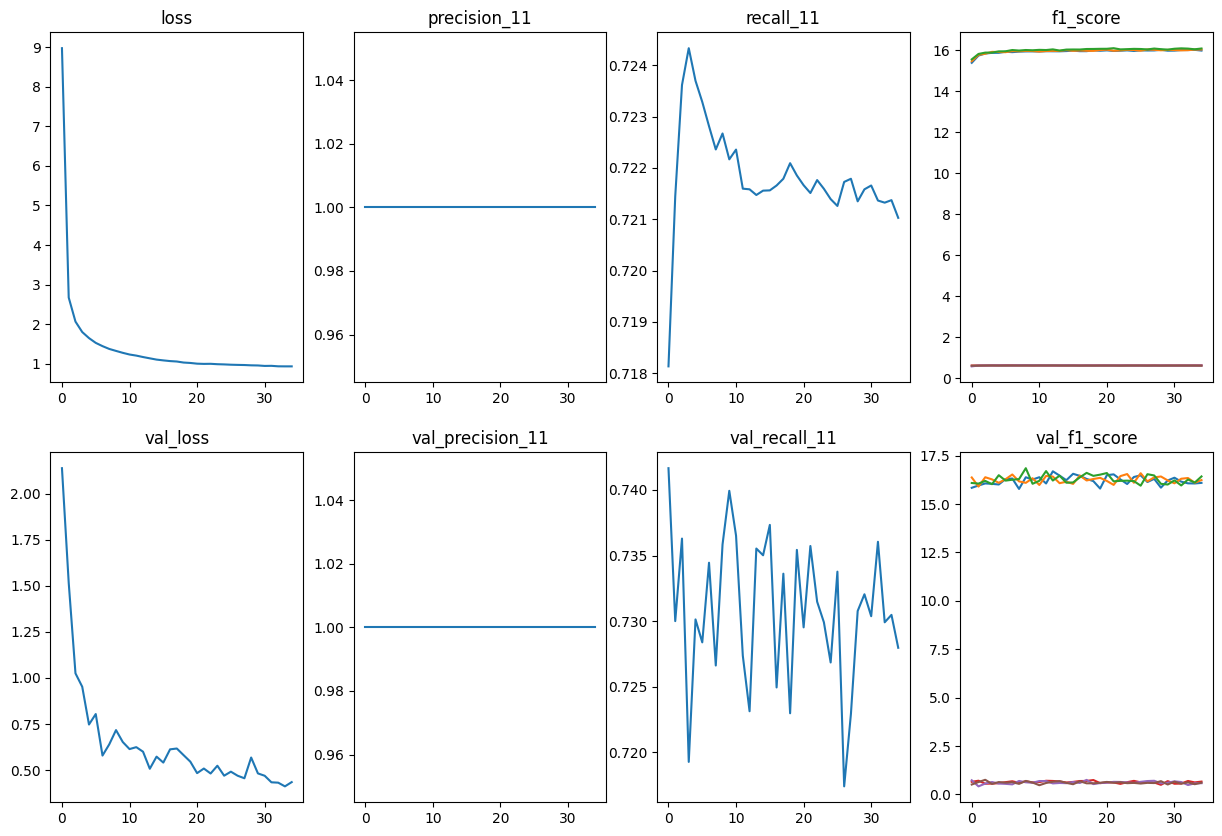

In [ ]:
def plot_history_metrics(history: keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

plot_history_metrics(hist)

### Produce test sample

(900, 3)


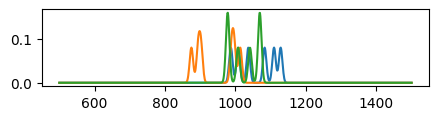

In [ ]:
points = np.row_stack(list(features.values()))
w0 = np.zeros(3)
V0 = np.zeros(3)

lhs(1, 1 , roll_range[0], roll_range[-1])

num_decim = 9
alpha = np.array([np.round(lhs(1, 1, roll_range[0], roll_range[-1]).flatten()[0], num_decim),
                  np.round(lhs(1, 1, roll_range[0], roll_range[-1]).flatten()[0], num_decim),
                  np.round(lhs(1, 1, roll_range[0], roll_range[-1]).flatten()[0], num_decim)])
V = V0 + alpha
w = w0 + lhs(3, 1, -10, 10)[0]
points_new = points.copy()

for i in range(len(points_new)):
    points_new[i] = p1_xyz(points_new[i], w, V)
# --------------------------------------------------------------

x = np.linspace(500, 1500, timesteps)
x_test_sample = np.zeros((feature_channels, timesteps))

for i, (_, sensor_pos) in enumerate(sensors.items()):

    distances = []

    for p in points_new:
        distances.append(p2(p, w, V, sensor_pos))

    y = np.zeros_like(x)
    sigma = 5

    for d in distances:
        # add a gaussian kernel for each distance
        gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
        y += gaussian_norm_const  * np.exp(-((x - d)**2) / (2 * sigma**2))

    x_test_sample[i, :] = y

x_test_sample = x_test_sample.T
y_test_sample = np.concatenate([w, V*(180/np.pi)])

print(x_test_sample.shape)
plt.figure(figsize=(5,1))
plt.plot(x, x_test_sample[:, 0])
plt.plot(x, x_test_sample[:, 1])
plt.plot(x, x_test_sample[:, 2])
# plt.xticks(ticks=range(500, 1500, 20), labels=range(500, 1500, 20))
plt.show()

### Make prediction

1/1 [==============================] - 0s 21ms/step
Actual pose:     [-7.2544 1.1046 -1.5268 8.6615 8.0325 1.4143]
Prediction pose: [-7.1588 0.4320 -1.2710 7.6701 7.8179 1.0024]


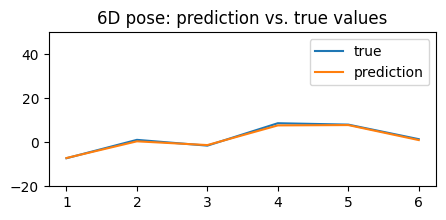

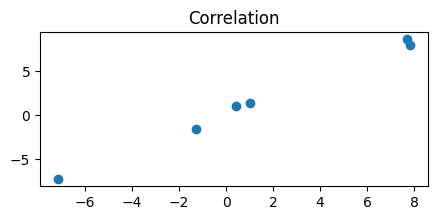

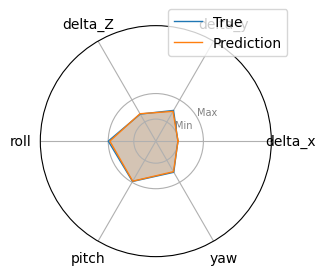

In [ ]:
# # extract sample from train dataset
batch0 = valid_dataset.take(1)
first_batch = next(iter(batch0))
sample0 = first_batch[0][0].numpy(), first_batch[1][0].numpy()

# sample0 = x_test_sample, y_test_sample

# make prediction
prediction = conv_model.predict(tf.expand_dims(sample0[0], axis=0)).flatten()

np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:2.4f}".format(x)})

print(f"Actual pose:     {sample0[1]}")
print(f"Prediction pose: {prediction}")

plt.figure(figsize=(5,2))
plt.title('6D pose: prediction vs. true values')
plt.plot(np.linspace(1, 6, 6), sample0[1], label='true')
plt.plot(np.linspace(1, 6, 6), prediction, label='prediction')
plt.ylim(-20, 50)
plt.legend()
plt.show()
plt.figure(figsize=(5,2))
plt.title('Correlation')
plt.plot(prediction, sample0[1], "o")
plt.show()

radar_plot(sample0[1], prediction)

### Run simulations

In [ ]:
def radar_plot(v1, v2, ax):
    num_vars = 6

    # split circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    v1 = np.concatenate((v1,[v1[0]]))
    v2 = np.concatenate((v2,[v2[0]]))
    angles += angles[:1]

    # fig, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

    # draw one axe per variable and add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(['delta_x', 'delta_y', 'delta_Z', 'roll', 'pitch', 'yaw'])


    # draw ylabels
    ax.set_rlabel_position(30)
    ax.set_yticks([-60, 0, 30], ["-60", "0", "30"], color="grey", size=7)
    ax.set_ylim(-90-6, 60+1)

    # plot data for first vector
    ax.plot(angles, v1, linewidth=1, linestyle='solid', label='True')
    ax.fill(angles, v1, alpha=0.25)

    # plot data for second vector
    ax.plot(angles, v2, linewidth=1, linestyle='solid', label='Prediction')
    ax.fill(angles, v2, alpha=0.25)


1/1 [==============================] - 0s 218ms/step

- test run 1. RMS: 0.53354.
    True pose:      [41.99654 38.90633 35.78166 -3.06436 0.72110 -55.42424]
    Predicted pose: [42.33548 39.20010 36.84219 -2.99567 0.74324 -56.03815]
    Error:          [0.33894 0.29377 1.06053 0.06869 0.02214 0.61391]


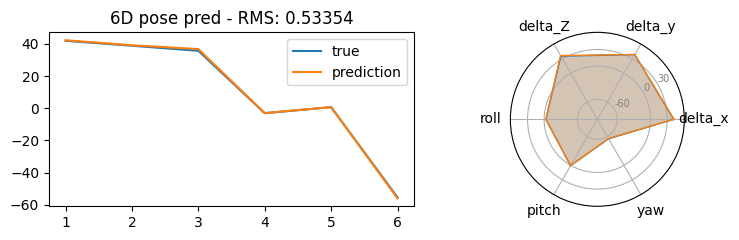

1/1 [==============================] - 0s 19ms/step

- test run 2. RMS: 0.42575.
    True pose:      [35.35475 43.76558 39.87162 3.22354 -0.48613 -62.91207]
    Predicted pose: [35.40815 43.21987 39.51481 2.96343 -0.60451 -62.15184]
    Error:          [0.05339 0.54571 0.35681 0.26011 0.11838 0.76023]


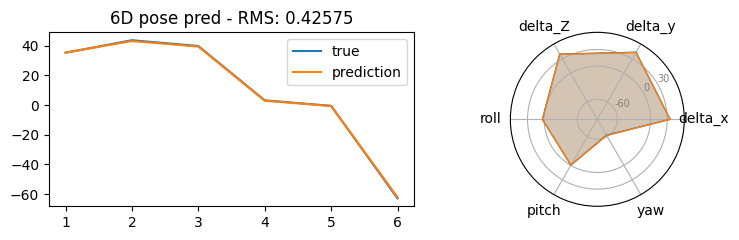

1/1 [==============================] - 0s 20ms/step

- test run 3. RMS: 0.42951.
    True pose:      [41.82825 41.46269 38.74598 1.36003 4.20496 -55.43363]
    Predicted pose: [41.19267 40.99818 38.90788 1.31488 3.53719 -55.54760]
    Error:          [0.63559 0.46451 0.16190 0.04514 0.66777 0.11397]


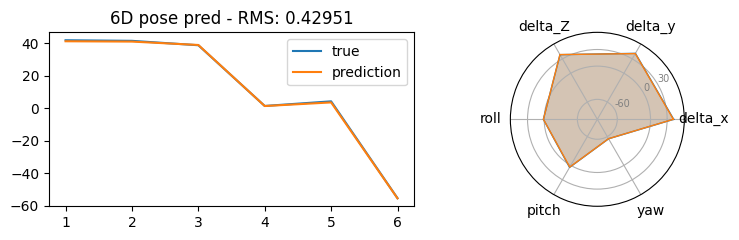

1/1 [==============================] - 0s 20ms/step

- test run 4. RMS: 0.38091.
    True pose:      [35.34789 41.04773 39.51458 -0.93728 2.10552 -62.23153]
    Predicted pose: [35.17319 40.63683 39.00528 -0.86429 1.95962 -61.61089]
    Error:          [0.17470 0.41090 0.50930 0.07300 0.14590 0.62064]


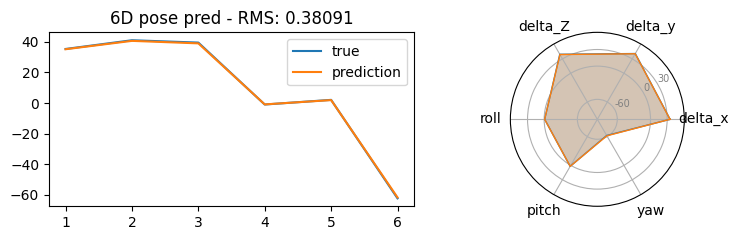

1/1 [==============================] - 0s 21ms/step

- test run 5. RMS: 0.63244.
    True pose:      [39.95576 41.89562 36.87611 4.15936 1.93080 -56.33586]
    Predicted pose: [39.44888 41.07399 37.85600 3.44856 1.89184 -56.36636]
    Error:          [0.50688 0.82163 0.97990 0.71080 0.03896 0.03050]


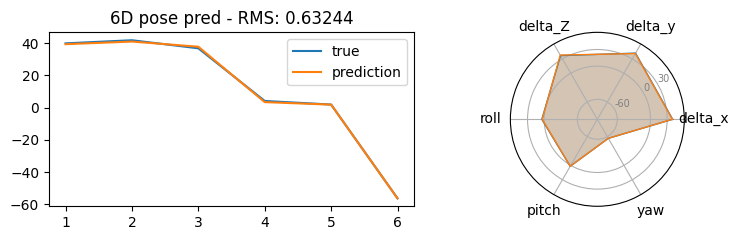

1/1 [==============================] - 0s 21ms/step

- test run 6. RMS: 0.28776.
    True pose:      [36.01833 39.44378 37.38097 0.46889 2.65010 -55.65194]
    Predicted pose: [35.39214 39.62012 37.54760 0.58343 2.58773 -55.82182]
    Error:          [0.62619 0.17635 0.16663 0.11454 0.06237 0.16988]


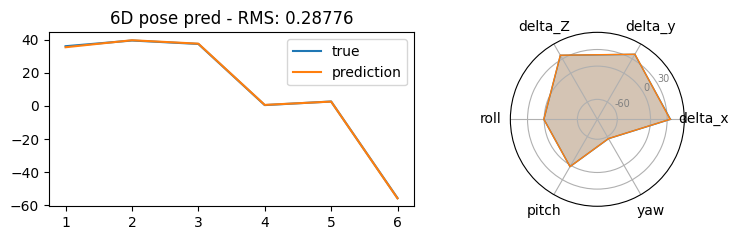

1/1 [==============================] - 0s 21ms/step

- test run 7. RMS: 0.34897.
    True pose:      [35.38789 42.94317 40.86544 -4.50994 1.21707 -63.35100]
    Predicted pose: [35.71460 42.83473 40.79479 -3.83004 0.99416 -63.04241]
    Error:          [0.32671 0.10844 0.07065 0.67990 0.22292 0.30859]


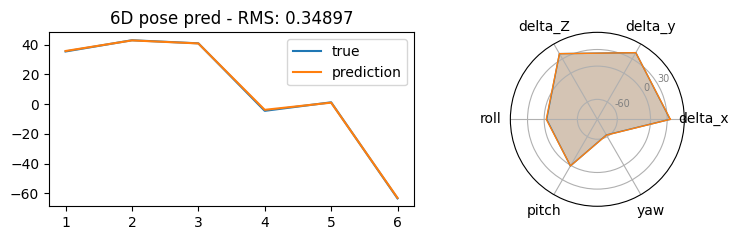

1/1 [==============================] - 0s 24ms/step

- test run 8. RMS: 0.22646.
    True pose:      [44.68866 37.26570 39.53936 0.58055 3.05283 -58.49479]
    Predicted pose: [44.37881 37.21447 39.62725 0.29636 2.73077 -58.36494]
    Error:          [0.30986 0.05123 0.08789 0.28419 0.32206 0.12985]


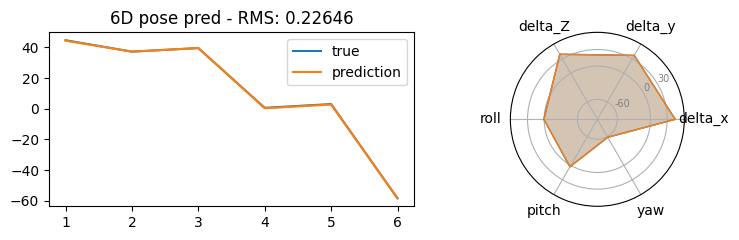

1/1 [==============================] - 0s 20ms/step

- test run 9. RMS: 0.28563.
    True pose:      [43.07613 44.97755 37.63503 2.75732 2.40705 -55.49157]
    Predicted pose: [42.81629 44.39772 37.59181 2.80619 2.48365 -55.76665]
    Error:          [0.25984 0.57983 0.04323 0.04886 0.07660 0.27509]


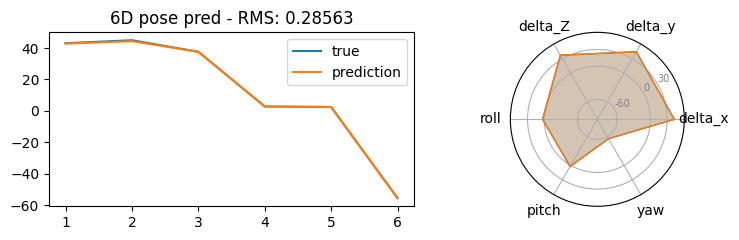

1/1 [==============================] - 0s 20ms/step

- test run 10. RMS: 0.38164.
    True pose:      [44.57387 40.72488 35.35816 -4.82723 4.22221 -57.61070]
    Predicted pose: [44.61812 40.47718 35.70693 -4.20334 3.68540 -57.50317]
    Error:          [0.04425 0.24770 0.34878 0.62389 0.53680 0.10753]


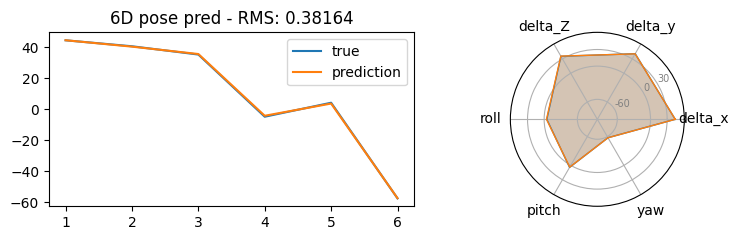

In [ ]:
w0 = np.zeros(3)
V0 = np.zeros(3)

delta_w = np.ones(3)*40
alpha = np.array([0, 0, -np.pi*(1/3)])

w0 = w0 + delta_w
V0 = V0 + alpha

num_simulations = 10

for r in range(num_simulations):

  points = np.row_stack(list(features.values()))
  # w0 = np.zeros(3)
  # V0 = np.zeros(3)

  num_decim = 10
  alpha = np.array([np.round(np.random.uniform(low=roll_range[0], high=roll_range[-1]), num_decim),
                    np.round(np.random.uniform(low=pitch_range[0], high=pitch_range[-1]), num_decim),
                    np.round(np.random.uniform(low=yaw_range[0], high=yaw_range[-1]), num_decim)])

  # alpha = np.array([lhs(1, 1 , roll_range[0], roll_range[-1]).flatten()[0],
  #                   lhs(1, 1 , roll_range[0], roll_range[-1]).flatten()[0],
  #                   lhs(1, 1 , roll_range[0], roll_range[-1]).flatten()[0]])

  V = V0 + alpha
  w = w0 + np.random.uniform(low=-5, high=5, size=(3))
  points_new = points.copy()

  for i in range(len(points_new)):
      points_new[i] = p1_xyz(points_new[i], w, V)
  # --------------------------------------------------------------

  x = np.linspace(500, 1500, timesteps)
  x_test_sample = np.zeros((feature_channels, timesteps))

  for i, (_, sensor_pos) in enumerate(sensors.items()):

      distances = []

      for p in points_new:
          distances.append(p2(p, w, V, sensor_pos))

      y = np.zeros_like(x)
      sigma = 5

      for d in distances:
          # add a gaussian kernel for each distance
          gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
          y += gaussian_norm_const  * np.exp(-((x - d)**2) / (2 * sigma**2))

      x_test_sample[i, :] = y

  x_test_sample = x_test_sample.T
  y_test_sample = np.concatenate([w, V*(180/np.pi)])


  # batch0 = valid_dataset.take(1)
  # first_batch = next(iter(batch0))
  # x_test_sample, y_test_sample = first_batch[0][0].numpy(), first_batch[1][0].numpy()


  # make prediction
  prediction = conv_model.predict(tf.expand_dims(x_test_sample, axis=0)).flatten()

  rmse = np.round(np.sqrt(np.mean((y_test_sample - prediction)**2)), 5)

  print(f"\n- test run {r+1}. RMS: {rmse}.")
  print(f"    True pose:      {y_test_sample}")
  print(f"    Predicted pose: {prediction}")
  print(f"    Error:          {np.abs(y_test_sample - prediction)}")
  # Creating a figure for both subplots
  fig = plt.figure(figsize=(8, 2.5))  # Adjusted figure size for horizontal layout

  # Adding the first subplot for the line plot
  ax1 = fig.add_subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
  ax1.set_title(f'6D pose pred - RMS: {rmse}')
  ax1.plot(np.linspace(1, 6, 6), y_test_sample, label='true')
  ax1.plot(np.linspace(1, 6, 6), prediction, label='prediction')
  ax1.legend()

  # Adding the second subplot for the radar plot
  ax2 = fig.add_subplot(1, 2, 2, polar=True)  # 1 row, 2 columns, 2nd subplot (polar)
  radar_plot(y_test_sample, prediction, ax2)

  plt.tight_layout()
  plt.show()